In [1]:
import os
from torch.utils.data import DataLoader,Dataset
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import cv2
import numpy as np
import pandas as pd
from torchvision import models
from pathlib import Path
# from fastai.vision import Path
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import os
import copy


### 목적변수 처리를 위한 OneHot Vector 생성준비¶

In [2]:
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# ALPHABET = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
# ALPHABET = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
# ALL_CHAR_SET = NUMBER + ALPHABET
ALL_CHAR_SET = NUMBER
ALL_CHAR_SET_LEN = len(ALL_CHAR_SET)
MAX_CAPTCHA = 6

In [3]:
print("ALL_CHAR_SET : {}".format(ALL_CHAR_SET))
print("ALL_CHAR_SET_LEN : {}".format(ALL_CHAR_SET_LEN))

ALL_CHAR_SET : ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
ALL_CHAR_SET_LEN : 10


#### One - Hot Labels
이제 우리의 정답 y를 one hot vector로 바꿉시다.
one hot vector이란 모든 벡터의 원소들 중 하나만 1인 벡터를 의미합니다.

예를 들어, one hot vector로 0를 표현하면 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 이 될 수 있겠죠.(36개)

In [4]:
def encode(a):
    onehot = [0]*ALL_CHAR_SET_LEN
    idx = ALL_CHAR_SET.index(a)
    onehot[idx] += 1
    return onehot

In [5]:
encode('0')
len(encode('0'))
print("encode('0') : {}".format(encode('0')))
print("len(encode('0')) : {}".format(len(encode('0'))))

encode('0') : [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
len(encode('0')) : 10


#### 일부 이미지 시각화하기
데이터 증가를 이해하기 위해 일부 학습용 이미지를 시각화해보겠습니다.

Number of images found:  1104
Shape of image:  (62, 175, 3)
Shape of image:  (62, 175, 3)
Shape of image:  (62, 175, 3)
Shape of image:  (62, 175, 3)


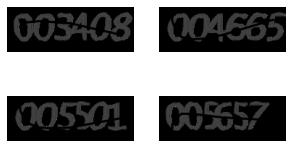

In [6]:
# Path to the data directory
# data_dir = Path("../input/captcha-version-2-images/samples/")
# data_dir = Path('captcha-version-2-images/samples/samples')
data_dir = Path('data/wetax')



# Get list of all the images
images = list(data_dir.glob("*.png"))
print("Number of images found: ", len(images))


# Let's take a look at some samples first. 
# Always look at your data!
sample_images = images[:4]

_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(str(sample_images[i]))
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

### 종속변수 처리를 위한 데이터셋 불러오기¶
torch.utils.data.DataLoader를 이용해서 입력 데이터를 불러온다. DataLoader의 입력 파라미터로는 (경로, Transform 옵션)을 포함하는 ImageFolder함수와 배치사이즈, 그리고 셔플 옵션이 있다. DataLoader의 파라미터 중 하나인 num_workers는 스레드 갯수를 설정하는 것인데, 필자의 경우 4로 했을 때 오류가 발생해서 스레드 갯수를 0으로 설정했다.

​

처음 볼 땐 난해한 문법들이 많을 텐데, 파이썬 딕셔너리 자료형에 대한 개념을 안다면 무난하게 이해할 수 있다. 잘 이해가 안된다면 딕셔너리 자료형에 대한 내용을 한번 읽고 오도록 하자.

In [7]:
class Mydataset(Dataset):
    def __init__(self, path, is_train=True, transform=None):
        self.path = path
        if is_train: self.img = os.listdir(self.path)[:1000]
        else: self.img = os.listdir(self.path)[1001:]
        try: self.img.remove('3bnfnd.png')
        except: pass
        self.transform = transform
        
    def __getitem__(self, idx):
        img_path = self.img[idx]
        img = Image.open(self.path/img_path)
        img = img.convert('L')
        label = Path(self.path/img_path).name[:-4]
        label_oh = []
        for i in label:
            label_oh += encode(i)
        if self.transform is not None:
            img = self.transform(img)
        return img, np.array(label_oh), label
    
    def __len__(self):
        return len(self.img)

In [8]:
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
])

In [9]:
train_ds = Mydataset(data_dir, transform=transform)
test_ds = Mydataset(data_dir, False, transform)
train_dl = DataLoader(train_ds, batch_size=64, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=1, num_workers=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

print("Number of training samples: ", len(train_ds))
print("Number of test samples: ", len(test_ds))



cuda:0
Number of training samples:  1000
Number of test samples:  103


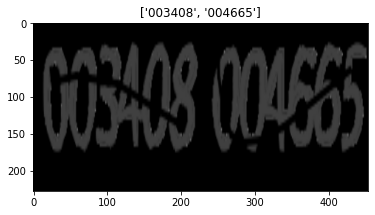

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.

# 학습 데이터의 배치를 얻습니다.
# 한개의 배치(batch)만큼 이미지를 불러온다. 배치 사이즈를 64로 했으니 사진 64장이 로드된다.
dataiter = iter(train_dl)
inputs, label_oh, classes = dataiter.next()


# 배치로부터 격자 형태의 이미지를 만듭니다.
# 로드된 데이터에 make_grid 함수를 통해 그리드를 추가한다.
# 로드된 데이터 중에서 4개만 추출한다.
out = torchvision.utils.make_grid(inputs[:2])

# 이미지를 출력한다.
imshow(out, title=[x for x in classes[:2]])


In [11]:
print("inputs")
print(inputs[0])
print(inputs.size())

inputs
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
torch.Size([64, 1, 224, 224])


In [12]:
print("label_oh")
print(label_oh[0])
print(label_oh.size())

label_oh
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=torch.int32)
torch.Size([64, 60])


In [13]:
print("classes")
print(classes[0])
print(len(classes))

classes
003408
64


### ResNet18 모델기반 신경망 정의하기
이제 신경망을 정의해보겠습니다

Transfer Learning의 핵심! Pretrained model을 가져온다. 본 예제에서는 ResNet18 모델을 이용하였다. model_ft.fc.in_features는 ResNet18모델의 마지막 단에서, 출력 노드의 갯수를 구해주는 함수이다. Pretrained-model의 끝단에 Fully connected layer를 추가로 삽입하고 노드를 연결시켜 주는 것이 우리가 사용할 모델이 된다. 가장 핵심이지만 가장 심플하다고 할 수 있다.

​

*이 때, Fully connected layer 즉 Linear layer의 출력 노드 갯수는 Class의 갯수와 같아야한다.

본 예제는 캡차에 적용된 영숫자와 인식필요 캡차영숫자의 곱으로 이루어진 ALL_CHAR_SET_LENMAX_CAPTCHA이므로, 출력 노드 갯수는 ALL_CHAR_SET_LENMAX_CAPTCHA가 된다.

In [14]:
def get_model():
    """
    """
    model = models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(in_features=512, out_features=ALL_CHAR_SET_LEN*MAX_CAPTCHA, bias=True)
    return model

# 모델 정의 
model = get_model().to(device)

### 손실함수정의

In [15]:
loss_func = nn.MultiLabelSoftMarginLoss()
optm = torch.optim.Adam(model.parameters(), lr=0.001)

### 모델 학습하기

In [16]:
since = time.time()
num_epochs = 50
for epoch in range(num_epochs):
    print(' ' * 50)
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    for step, i in enumerate(train_dl):
        img, label_oh, label = i
        img = Variable(img).to(device)
        label_oh = Variable(label_oh.float()).to(device)
        pred = model(img)
        loss = loss_func(pred, label_oh)
        optm.zero_grad()
        loss.backward()
        optm.step()
        print('step:', step+1, 'loss:', loss.item())

time_elapsed = time.time() - since
print('=' * 50)
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

                                                  
Epoch 1/50
----------


D:\arkwith\captcha\pytorch_env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


step: 1 loss: 0.7521631717681885
step: 2 loss: 0.5583084225654602
step: 3 loss: 0.4368396997451782
step: 4 loss: 0.3817189335823059
step: 5 loss: 0.33847466111183167
step: 6 loss: 0.35987141728401184
step: 7 loss: 0.34926891326904297
step: 8 loss: 0.34449639916419983
step: 9 loss: 0.3442017734050751
step: 10 loss: 0.35697370767593384
step: 11 loss: 0.34903305768966675
step: 12 loss: 0.34764760732650757
step: 13 loss: 0.3519682288169861
step: 14 loss: 0.3531894087791443
step: 15 loss: 0.35047271847724915
step: 16 loss: 0.3460926413536072
                                                  
Epoch 2/50
----------
step: 1 loss: 0.335207462310791
step: 2 loss: 0.331207275390625
step: 3 loss: 0.3280631899833679
step: 4 loss: 0.3239748477935791
step: 5 loss: 0.31766271591186523
step: 6 loss: 0.31735503673553467
step: 7 loss: 0.3139539361000061
step: 8 loss: 0.3213963508605957
step: 9 loss: 0.3185102641582489
step: 10 loss: 0.31957101821899414
step: 11 loss: 0.3188045620918274
step: 12 loss: 0.3

step: 6 loss: 0.10213025659322739
step: 7 loss: 0.09315602481365204
step: 8 loss: 0.1024334579706192
step: 9 loss: 0.08475152403116226
step: 10 loss: 0.10580801963806152
step: 11 loss: 0.08771775662899017
step: 12 loss: 0.09886309504508972
step: 13 loss: 0.08175878971815109
step: 14 loss: 0.09384050220251083
step: 15 loss: 0.09305103123188019
step: 16 loss: 0.08035653084516525
                                                  
Epoch 15/50
----------
step: 1 loss: 0.0959918349981308
step: 2 loss: 0.0790400356054306
step: 3 loss: 0.09937818348407745
step: 4 loss: 0.09141410887241364
step: 5 loss: 0.08840114623308182
step: 6 loss: 0.09256145358085632
step: 7 loss: 0.08101232349872589
step: 8 loss: 0.09225988388061523
step: 9 loss: 0.07145698368549347
step: 10 loss: 0.09373433887958527
step: 11 loss: 0.07062521576881409
step: 12 loss: 0.08674076199531555
step: 13 loss: 0.06820723414421082
step: 14 loss: 0.08775413781404495
step: 15 loss: 0.08263871818780899
step: 16 loss: 0.068063281476497

step: 8 loss: 0.035393126308918
step: 9 loss: 0.018672481179237366
step: 10 loss: 0.030363798141479492
step: 11 loss: 0.020931776612997055
step: 12 loss: 0.03090318664908409
step: 13 loss: 0.021304264664649963
step: 14 loss: 0.03152293339371681
step: 15 loss: 0.02696256712079048
step: 16 loss: 0.018670683726668358
                                                  
Epoch 28/50
----------
step: 1 loss: 0.028287678956985474
step: 2 loss: 0.018777962774038315
step: 3 loss: 0.03125518560409546
step: 4 loss: 0.023963801562786102
step: 5 loss: 0.023320045322179794
step: 6 loss: 0.02739669382572174
step: 7 loss: 0.020115040242671967
step: 8 loss: 0.027736352756619453
step: 9 loss: 0.01676417887210846
step: 10 loss: 0.029178211465477943
step: 11 loss: 0.01603306457400322
step: 12 loss: 0.02491234615445137
step: 13 loss: 0.01763996109366417
step: 14 loss: 0.026186414062976837
step: 15 loss: 0.022725332528352737
step: 16 loss: 0.01634581945836544
                                                  

step: 6 loss: 0.00718305166810751
step: 7 loss: 0.004970340058207512
step: 8 loss: 0.006724606268107891
step: 9 loss: 0.0042877402156591415
step: 10 loss: 0.007100648246705532
step: 11 loss: 0.004103643819689751
step: 12 loss: 0.006833056919276714
step: 13 loss: 0.004357663914561272
step: 14 loss: 0.006627819500863552
step: 15 loss: 0.0058886343613266945
step: 16 loss: 0.004355489742010832
                                                  
Epoch 41/50
----------
step: 1 loss: 0.006729945540428162
step: 2 loss: 0.004338047932833433
step: 3 loss: 0.006715184077620506
step: 4 loss: 0.005683870054781437
step: 5 loss: 0.005769793875515461
step: 6 loss: 0.00649188831448555
step: 7 loss: 0.004731560125946999
step: 8 loss: 0.005908147431910038
step: 9 loss: 0.004018955864012241
step: 10 loss: 0.0061969151720404625
step: 11 loss: 0.003822402562946081
step: 12 loss: 0.005963614210486412
step: 13 loss: 0.003998518455773592
step: 14 loss: 0.006487141363322735
step: 15 loss: 0.005659332033246756
st

### 모델 예측값 시각화하기
일부 이미지에 대한 예측값을 보여주는 일반화된 함수입니다.

In [18]:
def visualize_model(input_model, num_images=6):
    was_training = input_model.training
    input_model.eval()
    images_so_far = 0
    fig = plt.figure()
    test_correct = 0
    test_total = len(test_dl.dataset)
    print("test_total=",test_total)

    with torch.no_grad():
        for i, (inputs, label_oh, label) in enumerate(test_dl):
            
            view_image = torchvision.utils.make_grid(inputs)
            inputs = Variable(inputs).to(device)
#             labels = labels.to(device)

            outputs = input_model(inputs)
    
            c0 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]
            c1 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN*2])]
            c2 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*2:ALL_CHAR_SET_LEN*3])]
            c3 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*3:ALL_CHAR_SET_LEN*4])]
            c4 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*4:ALL_CHAR_SET_LEN*5])]
#             preds_label = '%s%s%s%s%s' % (c0, c1, c2, c3, c4)
            c5 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*5:ALL_CHAR_SET_LEN*6])]
            preds_label = '%s%s%s%s%s%s' % (c0, c1, c2, c3, c4, c5)

            correct = ""
            if label[0] == preds_label:
                test_correct += 1
                correct = "True"
            else:
                correct = "False"
                
            
            print("Lable : {} Prediction Lable : {} 맟춤여부 : {}".format(label[0], preds_label, correct))

            # 맞추지 못한 이미지를 출력한다.
            if (correct == "False") and (num_images > i):
                imshow(view_image, title='{} predicted: {}  {}'.format(i+1, preds_label, correct))

        input_model.train(mode=was_training)
        
    print(f'Test Accuracy: {(test_correct/test_total):.5f} ' +  f'({test_correct}/{test_total})')

### 모델 학습결과 테스트 데이터로 테스트

In [19]:
# visualize_model(model)

In [20]:
model.eval();

In [24]:
test_correct = 0
num_images=6
test_total = len(test_dl.dataset)
print("test_total=",test_total)

for step, (img, label_oh, label) in enumerate(test_dl):
    img = Variable(img).cuda()
    pred = model(img)

    c0 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]
    c1 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN*2])]
    c2 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*2:ALL_CHAR_SET_LEN*3])]
    c3 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*3:ALL_CHAR_SET_LEN*4])]
    c4 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*4:ALL_CHAR_SET_LEN*5])]
    c5 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*5:ALL_CHAR_SET_LEN*6])]
    preds_label = '%s%s%s%s%s%s' % (c0, c1, c2, c3, c4, c5)
    
    correct = ""
    if label[0] == preds_label:
        test_correct += 1
        correct = "True"
    else:
        correct = "False"
                
    print("Lable : {} Prediction Lable : {} 맟춤여부 : {}".format(label[0], preds_label, correct))

    # 맞추지 못한 이미지를 출력한다.
    if (correct == "False") and (num_images > step):
        imshow(view_image, title='{} predicted: {}  {}'.format(i+1, preds_label, correct))

#     print('label:', label[0], 'pred:', c)
print(f'Test Accuracy: {(test_correct/test_total):.5f} ' +  f'({test_correct}/{test_total})')

test_total= 103
Lable : 906355 Prediction Lable : 306355 맟춤여부 : False


NameError: name 'view_image' is not defined

### 학습한 모델 저장
지금까지 인공신경망을 구현하고 학습시켜 보았습니다. 이제 학습된 모델을 .pt 파일로 저장해 보겠습니다.

In [ ]:
torch.save(model.state_dict(), 'model/WETAX_Breaking_Model.pt')
print("save last model")


save() 를 실행하고 나면 학습된 신경망의 가중치를 내포하는 GIRO_Breaking_Model.pt 라는 파일이 생성됩니다.

아래 코드처럼 GIRO_Breaking_Model.pt.pt를 다시 load하는 것도 가능합니다.

In [ ]:
new_model = get_model().to(device)
new_model = new_model.eval()
new_model.load_state_dict(torch.load('model/WETAX_Breaking_Model.pt'))
print("load saved_model.")

#### 업로드한 모델로 다시한번 테스트

In [ ]:
visualize_model(new_model)

### 학습모델이용 캡차 이미지 숫자인식
이미지 파일을 주고 이미지 파일 내에 있는 글자를 출력한다

In [ ]:
# 코드 3-1

import matplotlib.pyplot as plt
from PIL import Image

img = Image.open('data/giro_test/SRVWR3.png')
# img = Image.open('captcha-version-2-images/captcha01.png')
# PIL 객체 확인
print("type: {}".format(type(img)))
# 이미지 흑백으로 변경, 크기변화: 150x150x3 > 150x150x1
img = img.convert("L") 
# 이미지 크기 조회
print("size of image: {}".format(img.size))
img

In [ ]:
# Process our image
def process_image(image_path):
    # Load Image
    img = Image.open(image_path)
    # Load Image
    img = img.convert('L')
    # Resize Image [1, 224, 224]
    img = transform(img)
    
    # Turn image into numpy array
    img = np.array(img)
    
    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    
#     # Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image

In [ ]:
input = process_image('data/giro_test/SRVWR3.png')
print(input.size())
plt.imshow(input.squeeze().detach().numpy(), cmap="gray")
plt.axis("off")
plt.show()
# image = input[:,0][:,None].type(torch.FloatTensor).to(device) # select only 1 channel (all channel equal)
# print(image.size())

In [ ]:
def get_predict(model, path):

    model.eval()
    predict_label = ""
    input = process_image(path)
    print(input.size())
    
    img = Variable(input).to(device)

    output = model(img)

    c0 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]
    c1 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN*2])]
    c2 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*2:ALL_CHAR_SET_LEN*3])]
    c3 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*3:ALL_CHAR_SET_LEN*4])]
    c4 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*4:ALL_CHAR_SET_LEN*5])]
    predict_label = '%s%s%s%s%s' % (c0, c1, c2, c3, c4)
#     c5 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*5:ALL_CHAR_SET_LEN*6])]
#     predict_label = '%s%s%s%s%s%s' % (c0, c1, c2, c3, c4, c5)

   
    return predict_label


In [ ]:
get_predict(new_model, 'data/giro_test/SRVWR3.png')